In [1]:
# Spark imports
import pyspark
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Python imports
import pandas as pd
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.config("SPARK_LOCAL_IP", "192.168.1.2") \
                            .appName("Pre-Preprocess Mission Log") \
                            .master("spark://192.168.1.2:7077") \
                            .config("spark.driver.cores", "2") \
                            .config("spark.driver.memory", "10g") \
                            .config("spark.executor.memory", "12g") \
                            .config("spark.executor.cores", "3") \
                            .config("spark.dynamicAllocation.shuffleTracking.enabled", "true") \
                            .config("spark.dynamicAllocation.enabled", "true") \
                            .config("spark.dynamicAllocation.minExecutors", "5") \
                            .config("spark.dynamicAllocation.maxExecutors", "8") \
                            .config("spark.executor.instances", "5") \
                            .getOrCreate()

# Path to Parquet file, can be modified as needed
data_paths = ["hdfs://192.168.1.2:9000/user/rplenkers-test/correlated_data/11111-CAR7575-202401/final_correlated_dataset_spring-2024/2024-07-08/Full_Dataset_Parquet/2021-12-12 - 2021-12-19/part-00000-729e82b3-3941-4c88-95a5-4c1f6c17151a-c000.snappy.parquet","hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-12 - 2021-12-19/part-00000-7c2e9adb-5430-4792-a42b-10ff5bbd46e8-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-19 - 2021-12-26/part-00000-3f86626a-1225-47f9-a5a2-0170b737e404-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-26 - 2022-01-02/part-00000-b1a9fc13-8068-4a5d-91b2-871438709e81-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-02 - 2022-01-09/part-00000-26e9208e-7819-451b-b23f-2e47f6d1e834-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-09 - 2022-01-16/part-00000-36240b61-b84f-4164-a873-d7973e652780-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-16 - 2022-01-23/part-00000-cbf26680-106d-40e7-8278-60520afdbb0e-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-06 - 2022-02-13/part-00000-df678a79-4a73-452b-8e72-d624b2732f17-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-13 - 2022-02-20/part-00000-1da06990-329c-4e38-913a-0f0aa39b388d-c000.snappy.parquet"
            ]
#Container to hold the processed DataFrames
df_list = []

#Loop through each path, load and process the data
for path in data_paths:
    # Load each dataset
    df = spark.read.parquet(path)

    # Select relevant columns
    df = df.select("ts", "duration", "orig_bytes", "resp_bytes", "orig_ip_bytes", "resp_ip_bytes")
    
    # Handle missing values
    df = df.fillna({
        "duration": 0,
        "orig_bytes": 0,
        "resp_bytes": 0,
        "orig_ip_bytes": 0,
        "resp_ip_bytes": 0
    })

    # Convert 'ts' to a timestamp
    df = df.withColumn("ts", F.from_unixtime("ts").cast("timestamp"))
    
    # Define window size and stride
    window_size = "15 minutes"
    stride = "5 minutes"
    
    # Aggregate data within overlapping time windows
    df_agg = df.groupBy(F.window("ts", window_size, stride)) \
        .agg(
            F.sum("orig_bytes").alias("sum_orig_bytes"),
            F.sum("resp_bytes").alias("sum_resp_bytes"),
            F.sum("orig_ip_bytes").alias("sum_orig_ip_bytes"),
            F.sum("resp_ip_bytes").alias("sum_resp_ip_bytes"),
            F.count("*").alias("connection_count")
        )

    # Flatten the window structure
    df_agg_flat = df_agg.select(
        F.col("window.start").alias("window_start"),
        F.col("window.end").alias("window_end"),
        "sum_orig_bytes",
        "sum_resp_bytes",
        "sum_orig_ip_bytes",
        "sum_resp_ip_bytes",
        "connection_count"
    )

    # Sort by window start time
    df_agg_sorted = df_agg_flat.orderBy("window_start")
    
    # Convert Spark DataFrame to Pandas for further analysis
    df_pandas_sorted = df_agg_sorted.toPandas()

    #Print the number of rows
    print(f" DataFrame for: {path} has total rows: {len(df_pandas_sorted)}")

    #Add to DataFrame List
    df_list.append(df_pandas_sorted)

#Split and preprocess datasets
df_train_list = []
df_test_list = []

for i, df_pandas_sorted in enumerate(df_list):
    #Split into train and test sets
    train_ratio = 0.7 #Change ratio as needed
    split_index = int(len(df_pandas_sorted) * train_ratio)
    df_train = df_pandas_sorted.iloc[:split_index].copy()
    df_test = df_pandas_sorted.iloc[split_index:].copy()

    #Nomarlize using the maximum value from the training set
    scaling_factor = df_train["sum_orig_bytes"].max()

    #Add check to ensure scaling factor does not cause a divide by zero
    if scaling_factor ==0:
        scaling_factor =1
    
    df_train["sum_orig_bytes_norm"] = df_train["sum_orig_bytes"] / scaling_factor
    df_train["sum_orig_bytes_log"] = np.log1p(df_train["sum_orig_bytes_norm"])
    df_test["sum_orig_bytes_norm"] = df_test["sum_orig_bytes"] / scaling_factor
    df_test["sum_orig_bytes_log"] = np.log1p(df_test["sum_orig_bytes_norm"])

    #Append to lists
    df_train_list.append(df_train)
    df_test_list.append(df_test)

    #Print the sizes of the new sets
    print(f"Dataset {i+1}:")
    print(f" Training set size: {len(df_train)} rows")
    print(f" Testing set size: {len(df_test)} rows")
    print("-" * 40)
    
    # Indicate the dataframe is finished loading
    print(f"Finished loading dataset {i+1}.")

24/11/25 10:43:51 WARN Utils: Your hostname, ubuntu-virtual-machine resolves to a loopback address: 127.0.1.1; using 192.168.1.145 instead (on interface ens33)
24/11/25 10:43:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/25 10:43:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


 DataFrame for: hdfs://192.168.1.2:9000/user/rplenkers-test/correlated_data/11111-CAR7575-202401/final_correlated_dataset_spring-2024/2024-07-08/Full_Dataset_Parquet/2021-12-12 - 2021-12-19/part-00000-729e82b3-3941-4c88-95a5-4c1f6c17151a-c000.snappy.parquet has total rows: 353


 DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-12 - 2021-12-19/part-00000-7c2e9adb-5430-4792-a42b-10ff5bbd46e8-c000.snappy.parquet has total rows: 494


 DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-19 - 2021-12-26/part-00000-3f86626a-1225-47f9-a5a2-0170b737e404-c000.snappy.parquet has total rows: 2018


 DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-26 - 2022-01-02/part-00000-b1a9fc13-8068-4a5d-91b2-871438709e81-c000.snappy.parquet has total rows: 2018


 DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-02 - 2022-01-09/part-00000-26e9208e-7819-451b-b23f-2e47f6d1e834-c000.snappy.parquet has total rows: 2010


 DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-09 - 2022-01-16/part-00000-36240b61-b84f-4164-a873-d7973e652780-c000.snappy.parquet has total rows: 2008


 DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-16 - 2022-01-23/part-00000-cbf26680-106d-40e7-8278-60520afdbb0e-c000.snappy.parquet has total rows: 278


 DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-06 - 2022-02-13/part-00000-df678a79-4a73-452b-8e72-d624b2732f17-c000.snappy.parquet has total rows: 69
 DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-13 - 2022-02-20/part-00000-1da06990-329c-4e38-913a-0f0aa39b388d-c000.snappy.parquet has total rows: 41
Dataset 1:
 Training set size: 247 rows
 Testing set size: 106 rows
----------------------------------------
Finished loading dataset 1.
Dataset 2:
 Training set size: 345 rows
 Testing set size: 149 rows
----------------------------------------
Finished loading dataset 2.
Dataset 3:
 Training set size: 1412 rows
 Testing set size: 606 rows
----------------------------------------
Finished loading dataset 3.
Dataset 4:
 Training set size: 1412 rows
 Testing set size: 606 rows
----------------------------------------
Finished loading dataset 4.
Dataset 5:
 Training set size: 1407 rows
 Testing set size: 603 rows

Train ARIMA Model

Visualize DataFrame that is Used for Training

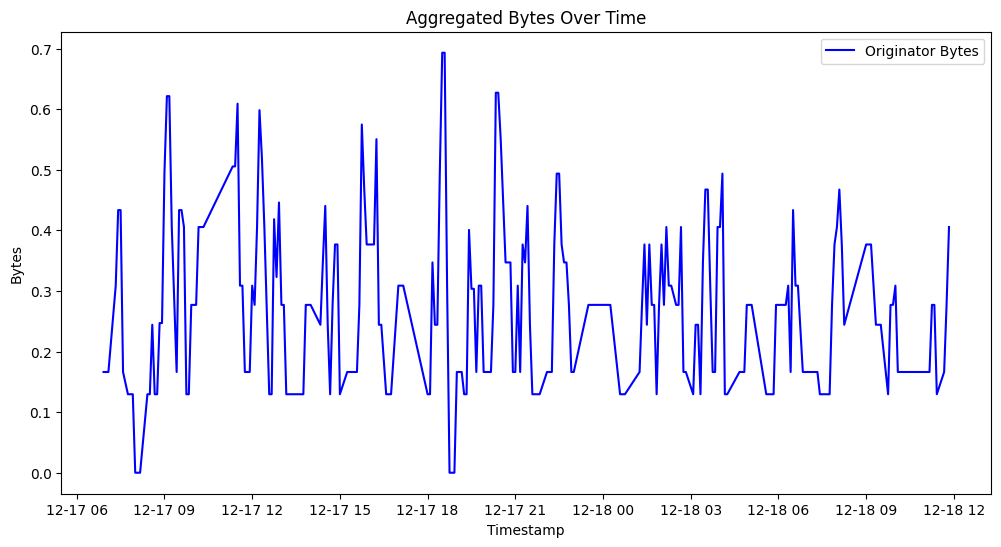

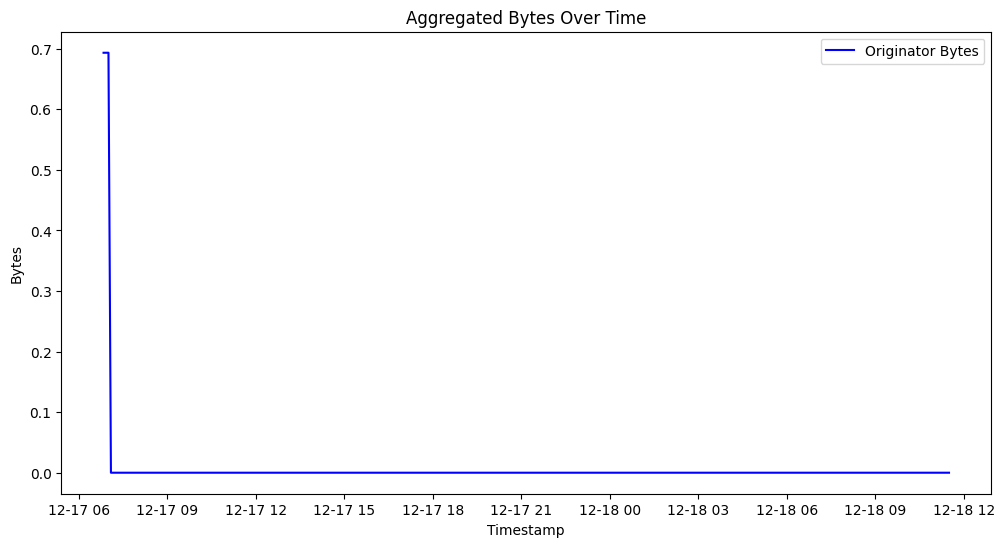

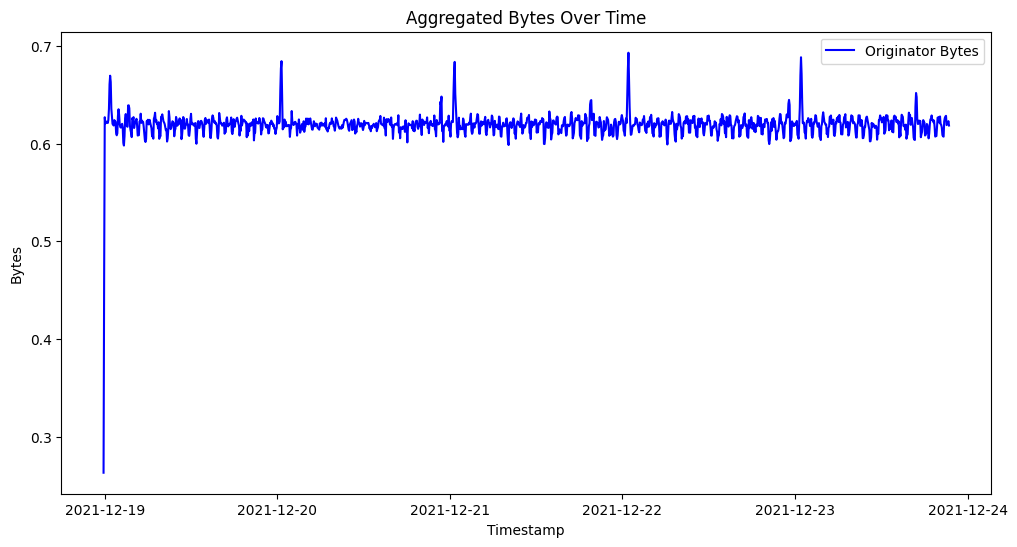

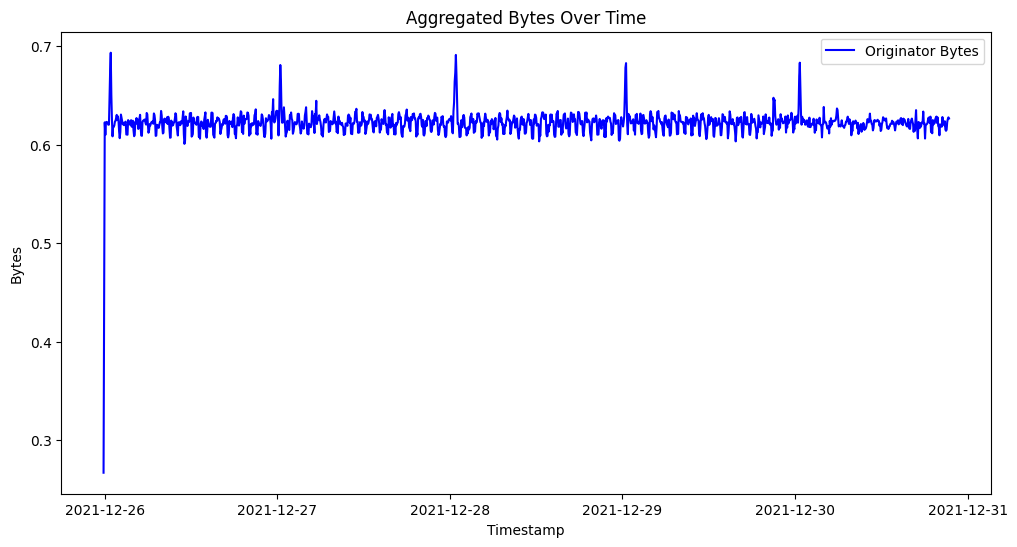

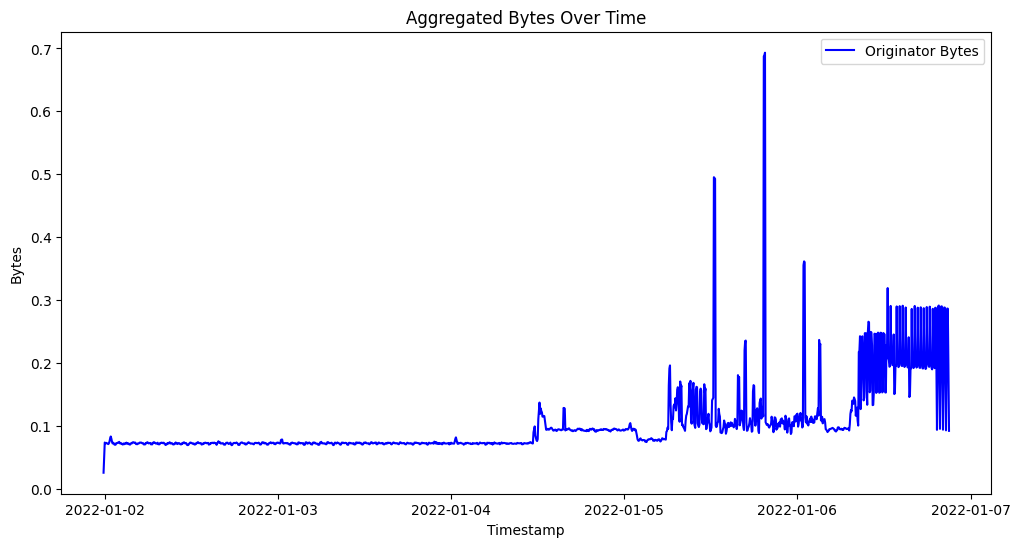

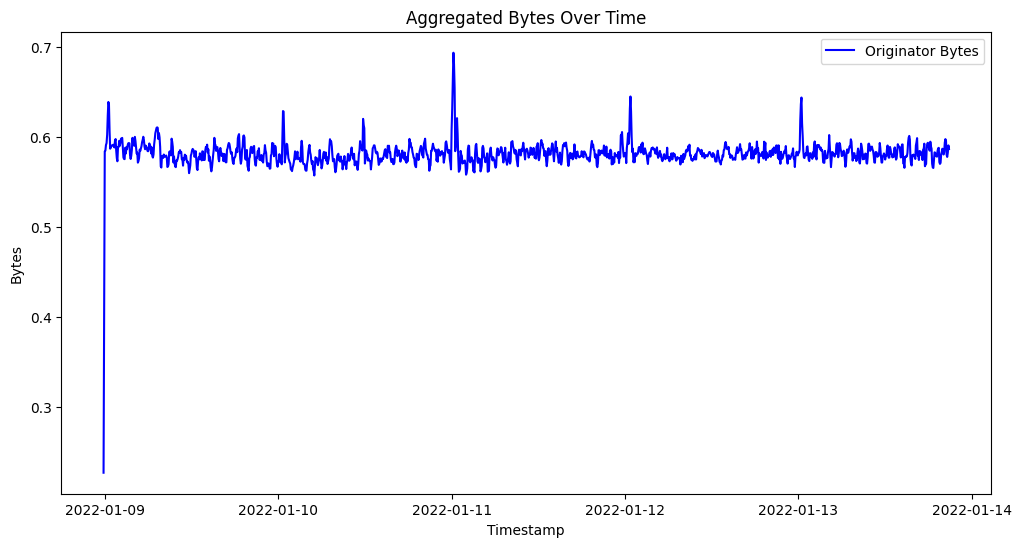

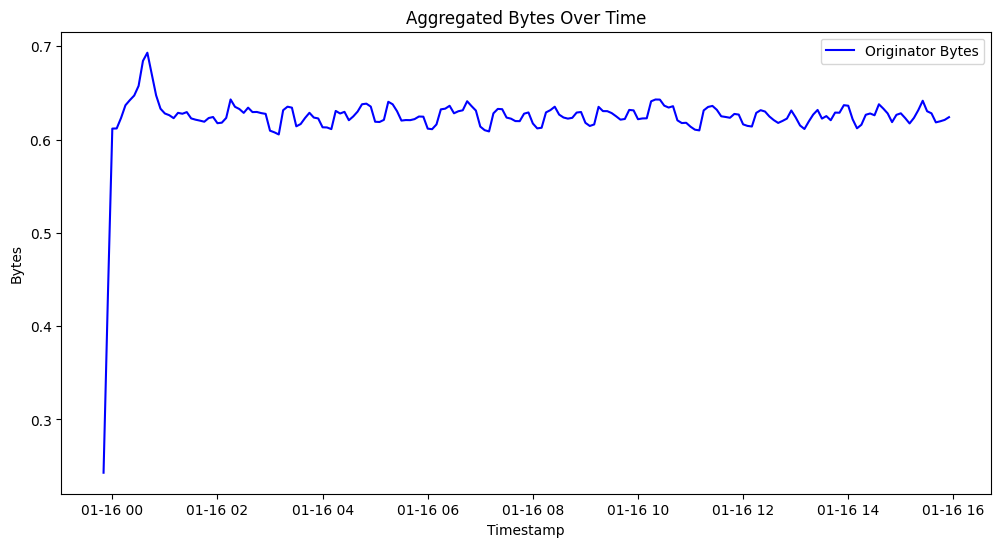

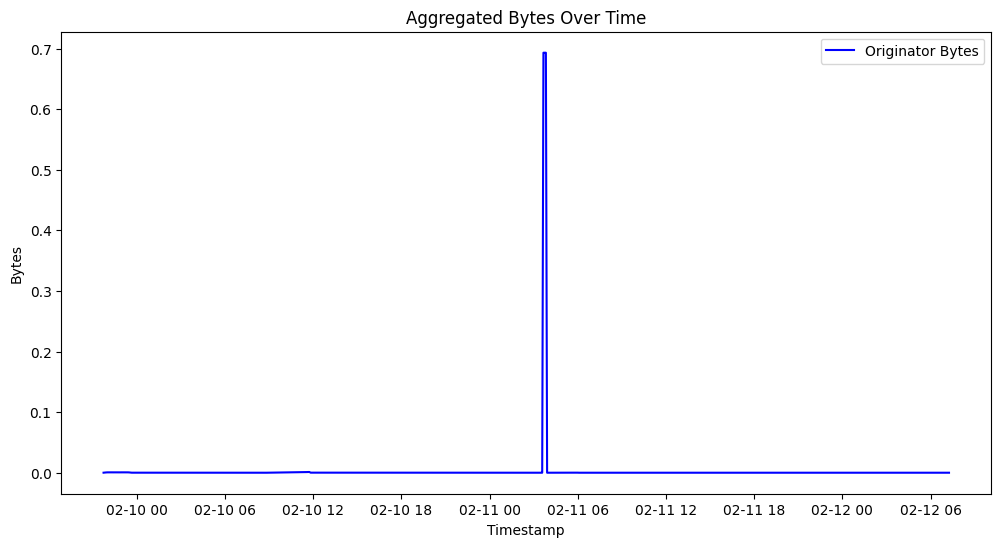

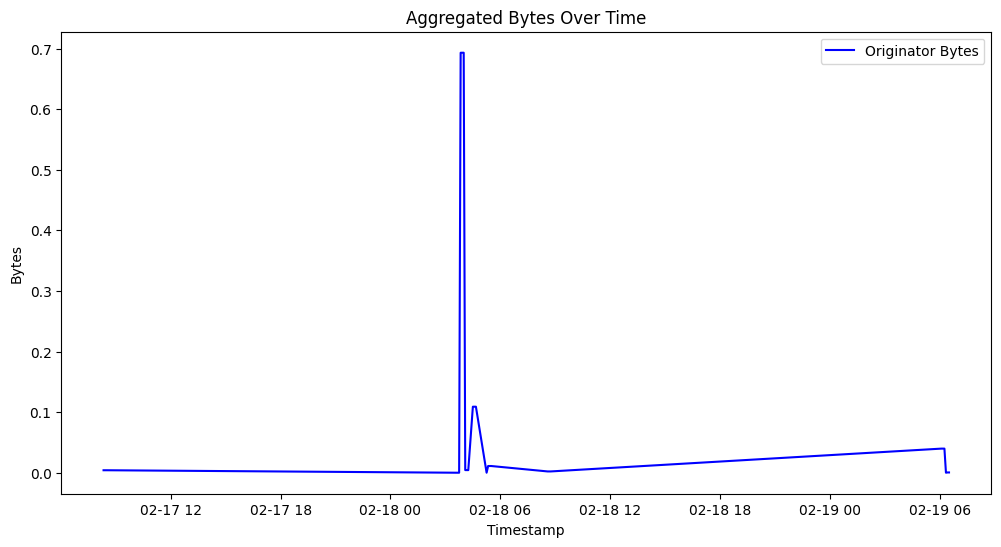

In [2]:
import matplotlib.pyplot as plt
for i, df_train in enumerate(df_train_list):

    #Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(df_train['window_start'], df_train['sum_orig_bytes_log'], label = 'Originator Bytes', color = 'blue')
    #plt.plot(df_train['window_start'], df_train['sum_resp_bytes_log'], label = 'Response Bytes', color = 'red')
    
    #Titles and Labels
    plt.xlabel('Timestamp')
    plt.ylabel('Bytes')
    plt.title('Aggregated Bytes Over Time')
    plt.legend()
    plt.show()

Stationarity Test

In [3]:
#Check for Stationarity Using Augmented Dickey-Fuller (ADF) Test
#Consider p-value threshold of 0.05
from statsmodels.tsa.stattools import adfuller
for i, df_train in enumerate(df_train_list):   
    #Perform ADF test on the 'sum_orig_bytes' time series
    result = adfuller(df_train['sum_orig_bytes_log'].dropna())
    
    #Extract and print test statistics
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values: ')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    #Interpret the result
    if result[1] < 0.05:
        print(f"The time series for dataset {i+1} is stationary (reject H0)")
    else:
        print(f"The time series for dataset {i+1} is non-stationary (fail to reject H0)")

ADF Statistic: -5.598163
p-value: 0.000001
Critical Values: 
	1%: -3.458
	5%: -2.874
	10%: -2.573
The time series for dataset 1 is stationary (reject H0)
ADF Statistic: -3.775825
p-value: 0.003165
Critical Values: 
	1%: -3.450
	5%: -2.870
	10%: -2.571
The time series for dataset 2 is stationary (reject H0)
ADF Statistic: -7.139684
p-value: 0.000000
Critical Values: 
	1%: -3.435
	5%: -2.864
	10%: -2.568
The time series for dataset 3 is stationary (reject H0)
ADF Statistic: -7.223496
p-value: 0.000000
Critical Values: 
	1%: -3.435
	5%: -2.864
	10%: -2.568
The time series for dataset 4 is stationary (reject H0)
ADF Statistic: -1.561348
p-value: 0.502975
Critical Values: 
	1%: -3.435
	5%: -2.864
	10%: -2.568
The time series for dataset 5 is non-stationary (fail to reject H0)
ADF Statistic: -6.336483
p-value: 0.000000
Critical Values: 
	1%: -3.435
	5%: -2.864
	10%: -2.568
The time series for dataset 6 is stationary (reject H0)
ADF Statistic: -5.710560
p-value: 0.000001
Critical Values: 
	1%

Plot of ACF and PACF from Stationary Series

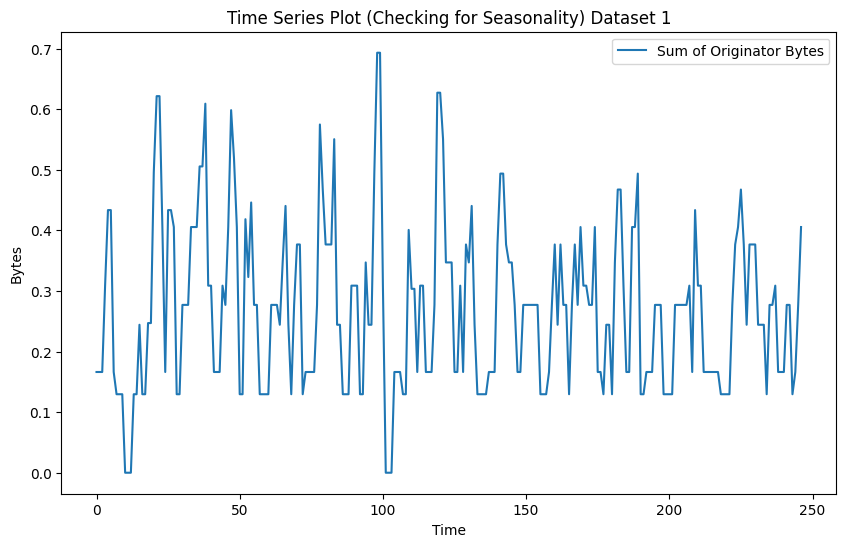

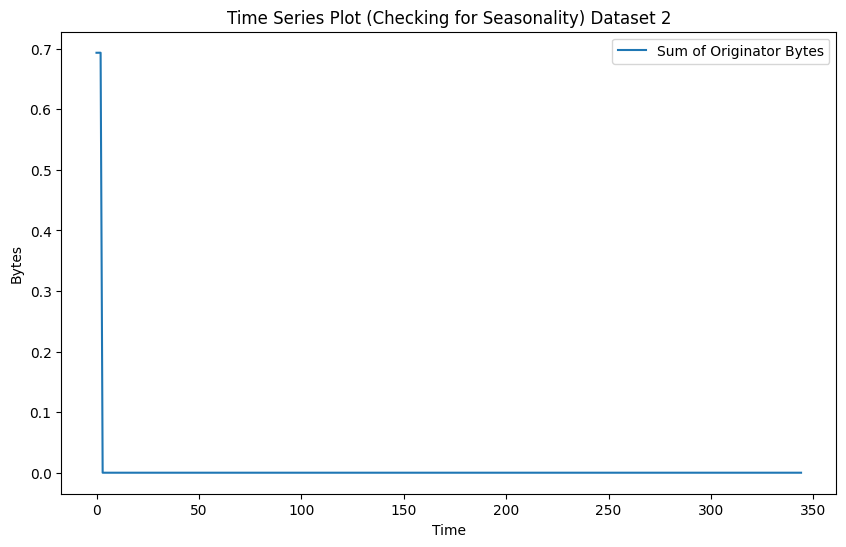

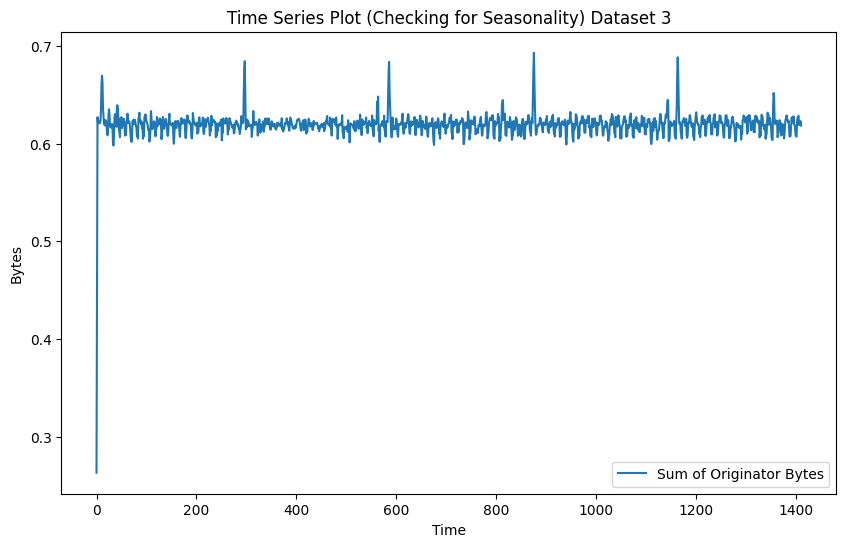

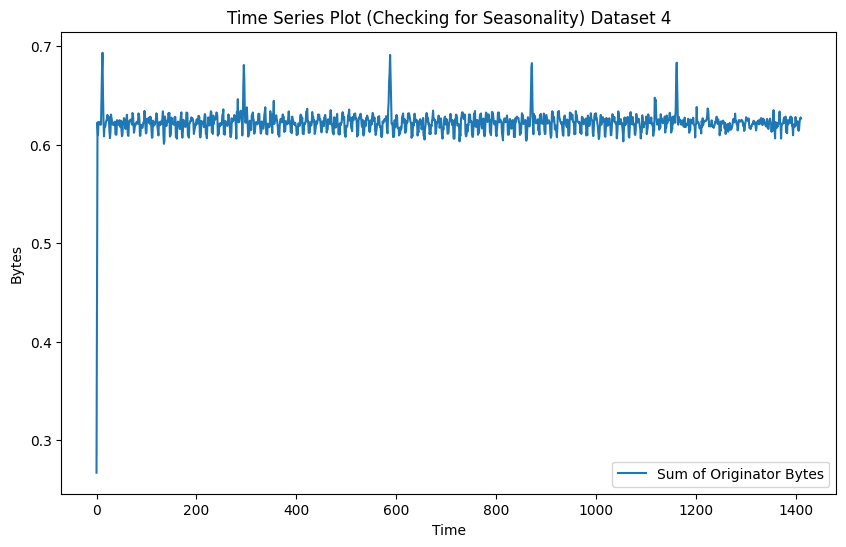

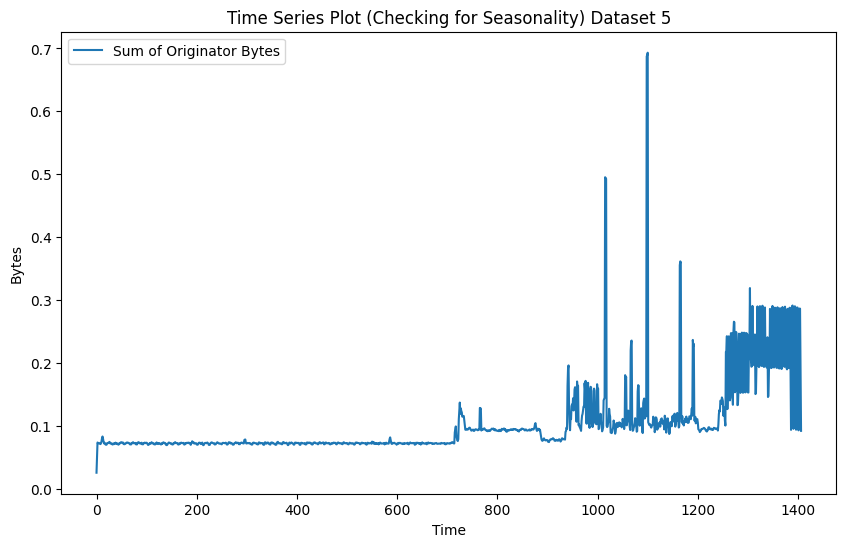

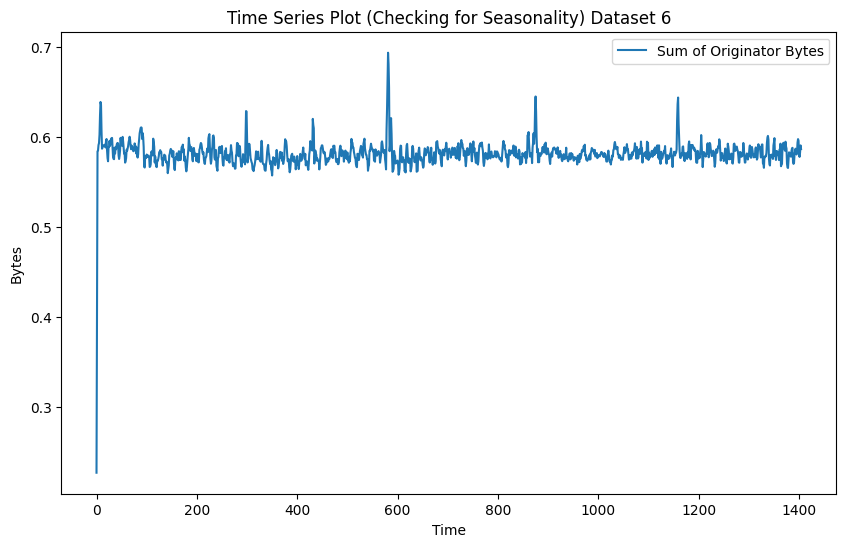

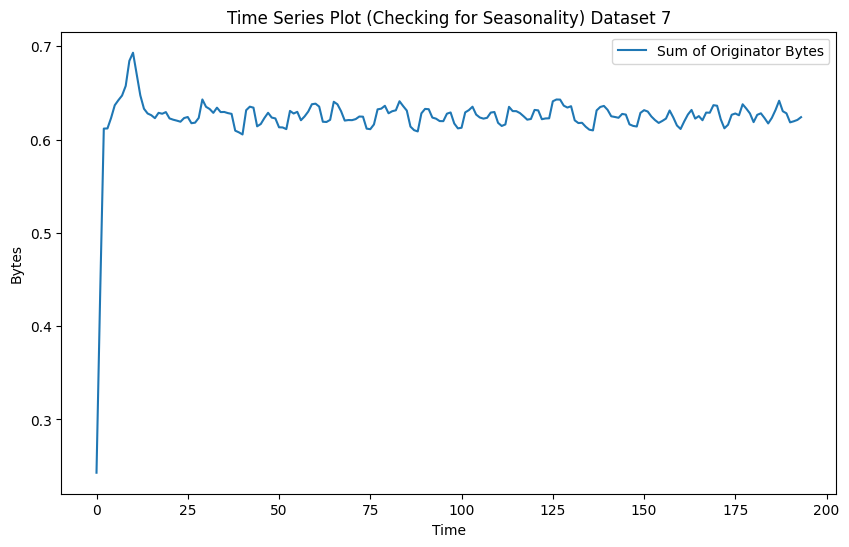

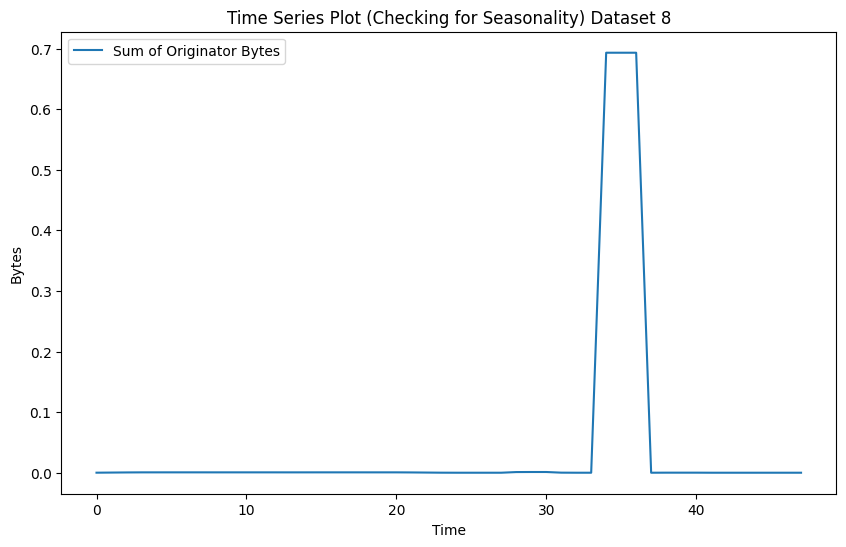

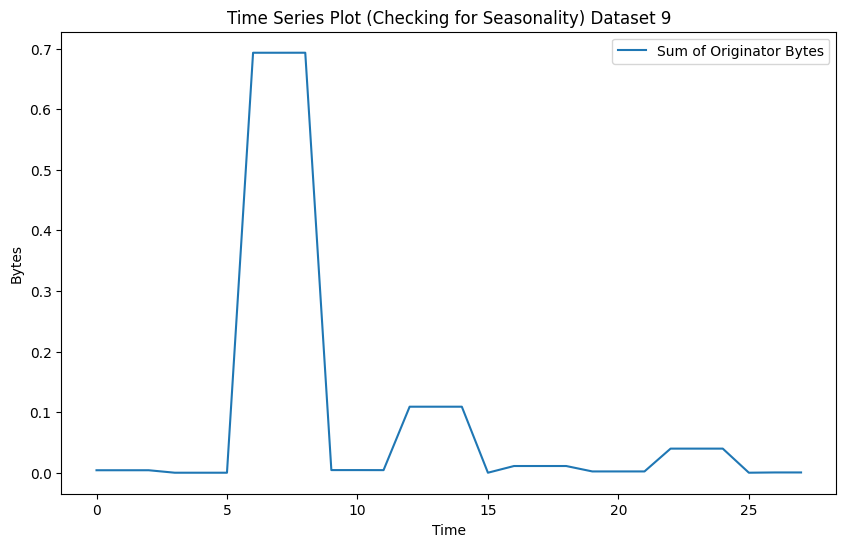

In [4]:
#Check for seasonality
import matplotlib.pyplot as plt
for i, df_train in enumerate(df_train_list):
    #Plot the original time series
    plt.figure(figsize=(10,6))
    plt.plot(df_train['sum_orig_bytes_log'], label='Sum of Originator Bytes')
    plt.title(f'Time Series Plot (Checking for Seasonality) Dataset {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Bytes')
    plt.legend()
    plt.show()

The time series for dataset 1 shows evidence of seasonality with a period of 4.


<Figure size 1000x600 with 0 Axes>

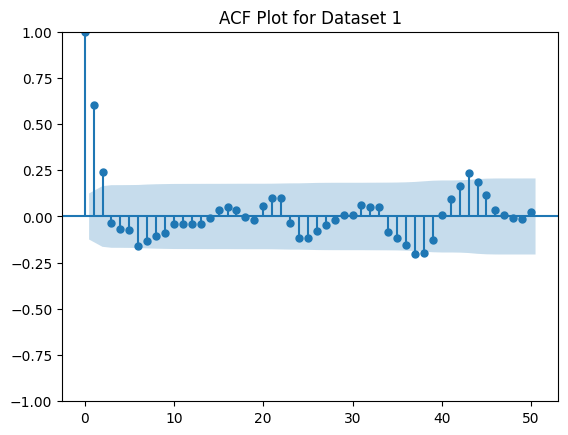

The time series for dataset 2 does not show significant evidence of seasonality.


<Figure size 1000x600 with 0 Axes>

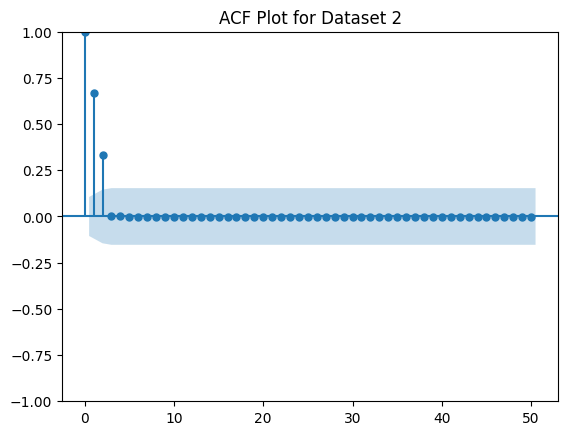

The time series for dataset 3 shows evidence of seasonality with a period of 2.


<Figure size 1000x600 with 0 Axes>

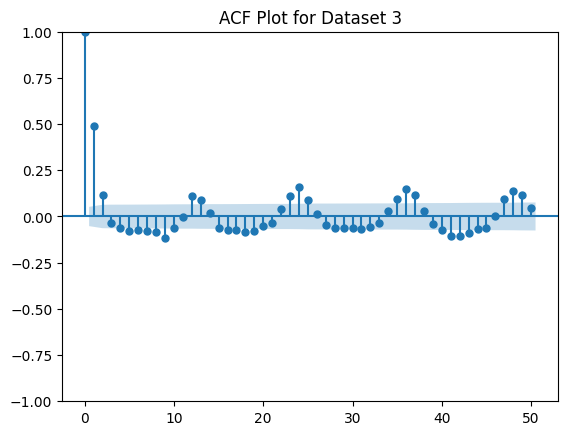

The time series for dataset 4 shows evidence of seasonality with a period of 6.


<Figure size 1000x600 with 0 Axes>

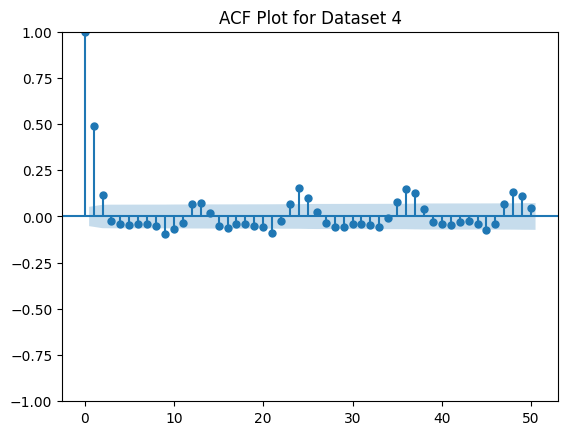

The time series for dataset 5 does not show significant evidence of seasonality.


<Figure size 1000x600 with 0 Axes>

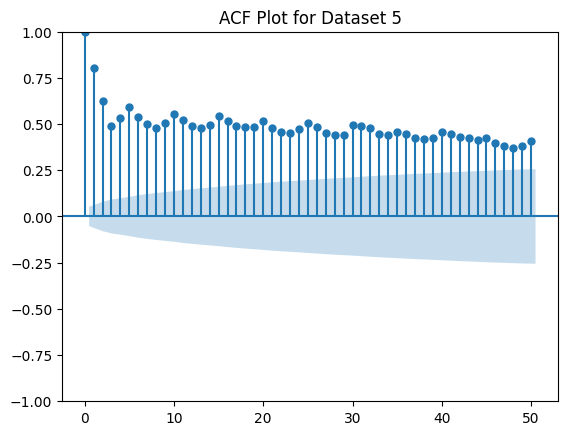

The time series for dataset 6 shows evidence of seasonality with a period of 3.


<Figure size 1000x600 with 0 Axes>

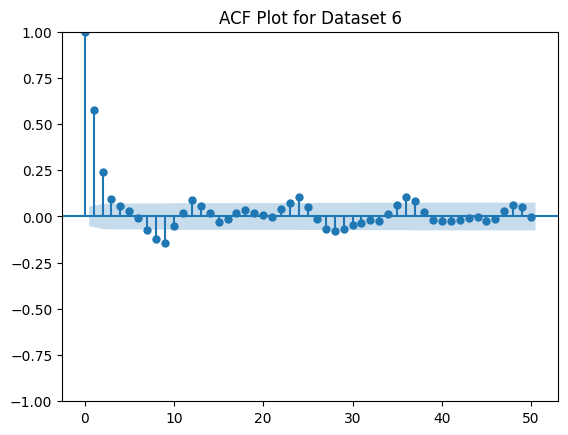

The time series for dataset 7 shows evidence of seasonality with a period of 8.


<Figure size 1000x600 with 0 Axes>

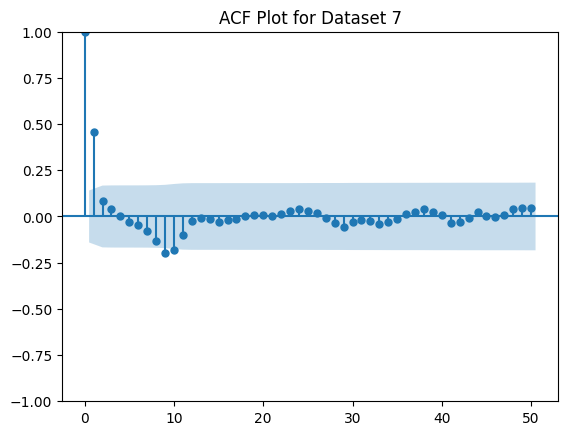

The time series for dataset 8 does not show significant evidence of seasonality.


<Figure size 1000x600 with 0 Axes>

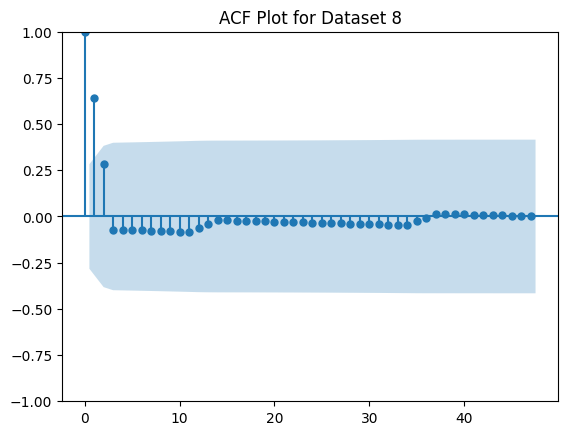

The time series for dataset 9 does not show significant evidence of seasonality.


<Figure size 1000x600 with 0 Axes>

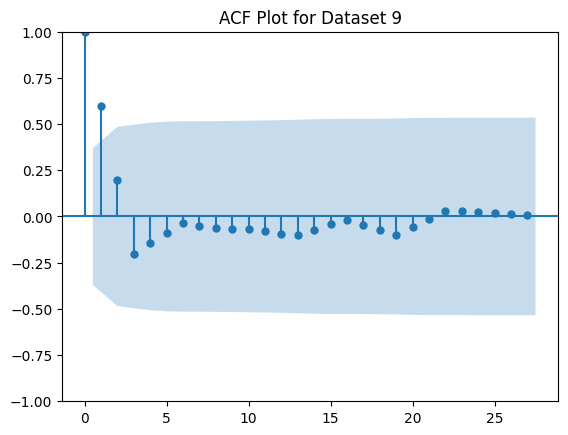

Seasonal periods detected: [4, None, 2, 6, None, 3, 8, None, None]


In [5]:
# Seasonality with ACF
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

seasonal_list = []  # 1 for seasonal, 0 for non-seasonal
seasonal_periods = []  # Record the seasonal period (m) for each dataset

for i, df_train in enumerate(df_train_list):
    # Calculate the maximum number of lags based on data length
    max_lags = min(50, len(df_train['sum_orig_bytes_log']) - 1)  # Ensure we don't exceed the data length
   
    # Calculate ACF Values
    acf_values = acf(df_train['sum_orig_bytes_log'], nlags=max_lags)

   
    # Threshold for significance (1.96/sqrt(N), where N is the number of observations)
    threshold = 1.96 / (len(df_train['sum_orig_bytes_log']) ** 0.5)
   
    # Identify significant lags
    significant_lags = [lag for lag, value in enumerate(acf_values) if abs(value) > threshold]
   
    # Determine if the dataset is seasonal
    seasonal = False
    seasonal_period = None
   
    for j in range(1, len(significant_lags)):
        # Calculate the gap between significant lags
        lag_gap = significant_lags[j] - significant_lags[j-1]
        if lag_gap > 1:  # Avoid immediate autocorrelations
            seasonal = True
            seasonal_period = lag_gap
            break
   
    # Record results
    if seasonal:
        print(f"The time series for dataset {i+1} shows evidence of seasonality with a period of {seasonal_period}.")
        seasonal_list.append(1)
        seasonal_periods.append(seasonal_period)
    else:
        print(f"The time series for dataset {i+1} does not show significant evidence of seasonality.")
        seasonal_list.append(0)
        seasonal_periods.append(None)  # No seasonality detected
   
    # Plot the ACF for visual purposes
    plt.figure(figsize=(10, 6))
    plot_acf(df_train['sum_orig_bytes_log'], lags=max_lags)
    plt.title(f"ACF Plot for Dataset {i+1}")
    plt.show()

# Print the seasonal periods found for reference
print("Seasonal periods detected:", seasonal_periods)

Determine p and q values using auto_arima() instead of graphical interpretation

In [6]:
from pmdarima import auto_arima

# Define lists for p, d, q
p_list = []
d_list = []
q_list = []

# Iterate over the datasets
for i, df_train in enumerate(df_train_list):
    # Get the seasonal period from the seasonal_list (if available)
    seasonal_period = seasonal_periods[i] if seasonal_list[i] == 1 else None  # Use the seasonal period found or None if no seasonality
   
    print(f"Fitting auto_arima for dataset {i+1}...")
   
    try:
        # Fit auto_arima to find optimal p, d, q values based on seasonality

        if seasonal_list[i] == 1:  # If seasonality is detected
            auto_model = auto_arima(df_train['sum_orig_bytes_log'],
                                    start_p=0, max_p=14,  # Range for p
                                    start_q=0, max_q=5,   # Range for q
                                    d=None,                # Let auto_arima determine d
                                    seasonal=True,         # Seasonality is detected
                                    m=seasonal_period,     # Use the seasonal period found
                                    trace=True,            # Output the process
                                    error_action='ignore',
                                    suppress_warnings=True,
                                    stepwise=True)
        else:  # If no seasonality is detected
            auto_model = auto_arima(df_train['sum_orig_bytes_log'],
                                    start_p=0, max_p=14,  # Range for p
                                    start_q=0, max_q=5,   # Range for q
                                    d=None,                # Let auto_arima determine d
                                    seasonal=False,        # No seasonality detected
                                    trace=True,            # Output the process
                                    error_action='ignore',
                                    suppress_warnings=True,
                                    stepwise=True)
       
        # Print the summary of the best model found
        print(f"Summary for Dataset {i+1}:")
        print(auto_model.summary())

        # Get the best values of p, d, and q
        p, d, q = auto_model.order

        p_list.append(p)
        d_list.append(d)
        q_list.append(q)

        print(f"Best p: {p}, d: {d}, q: {q} for Dataset {i+1}")
   
    except Exception as e:
        print(f"Error fitting auto_arima model for dataset {i+1}: {e}")
        print("Proceeding with fallback options.")


Fitting auto_arima for dataset 1...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=-282.277, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=-282.479, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=-392.187, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=-371.877, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=111.681, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=-393.673, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=-392.207, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=-389.803, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=-402.230, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[4] intercept   : AIC=-400.234, Time=0.15 sec
 ARIMA(2,0,0)(0,0,1)[4] intercept   : AIC=-400.234, Time=0.24 sec
 ARIMA(2,0,0)(1,0,1)[4] intercept   : AIC=-398.231, Time=0.41 sec
 ARIMA(3,0,0)(0,0,0)[4] intercept   : AIC=-405.500, Time=0.04 sec
 ARIMA(3,0,0)(1,0,0)[4] intercept   : AIC=-405.497, Time=0.27 se

Fit ARIMA Model based on p,d,q

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# Initialize a list to store fitted models
fitted_models = []

# Iterate through each dataset and corresponding p, d, q values
for i, (df_train, p, d, q) in enumerate(zip(df_train_list, p_list, d_list, q_list)):
    print(f"Fitting ARIMA model for dataset {i+1} with parameters (p={p}, d={d}, q={q})")

    try:
        # Fit the ARIMA model with seasonal=True based on ACF analysis
        model = SARIMAX(df_train['sum_orig_bytes_log'], order=(p, d, q), seasonal_order=(1, 1, 1, seasonal_period))
        model_fit = model.fit(disp=False)

        # Append the fitted model to the list
        fitted_models.append(model_fit)

        # Print the summary of the fitted model
        print(model_fit.summary())

    except Exception as e:
        print(f"Error fitting seasonal model for dataset {i+1}: {e}")
        print("Refitting model with no seasonality...")

        # Refitting the ARIMA model with no seasonality (seasonal=False)
        try:
            model = SARIMAX(df_train['sum_orig_bytes_log'], order=(p, d, q), seasonal_order=(0, 0, 0, 0))
            model_fit = model.fit(disp=False)

            # Append the fitted model to the list
            fitted_models.append(model_fit)

            # Print the summary of the fitted model
            print(model_fit.summary())

        except Exception as e2:
            print(f"Error fitting non-seasonal model for dataset {i+1}: {e2}")

# After the loop, 'fitted_models' will contain all the trained models
print(f"Total successfully fitted models: {len(fitted_models)}")

Fitting ARIMA model for dataset 1 with parameters (p=3, d=0, q=0)
Error fitting seasonal model for dataset 1: '<' not supported between instances of 'NoneType' and 'int'
Refitting model with no seasonality...
                               SARIMAX Results                                
Dep. Variable:     sum_orig_bytes_log   No. Observations:                  247
Model:               SARIMAX(3, 0, 0)   Log Likelihood                 177.805
Date:                Mon, 25 Nov 2024   AIC                           -347.611
Time:                        10:48:18   BIC                           -333.573
Sample:                             0   HQIC                          -341.959
                                - 247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
a

Diagnostic Tests

Dataset 1

Ljung-Box Test:
      lb_stat  lb_pvalue
10  34.233398   0.000169

Recommended lb_pvalue is > 0.05

Jarque-Bera Test:
JB Test Stat: 4.639661970621584, p-value: 0.09829019668760881

Recommended p-value is > 0.05

Durbin-Watson Test:
Durbin-Watson Stat: 2.0264527907277228

Recommended stat close to 2.0 but not greater than 2.0

RMSE:
Root Mean Squared Error: 0.11774720370030548


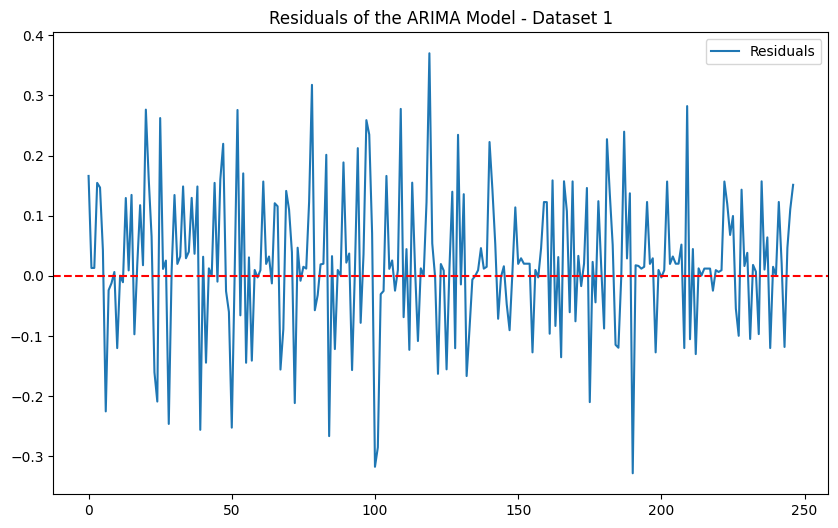

Dataset 2

Ljung-Box Test:
      lb_stat     lb_pvalue
10  87.279424  1.851543e-14

Recommended lb_pvalue is > 0.05

Jarque-Bera Test:
JB Test Stat: 412386.9297002611, p-value: 0.0

Recommended p-value is > 0.05

Durbin-Watson Test:
Durbin-Watson Stat: 1.4852689872736085

Recommended stat close to 2.0 but not greater than 2.0

RMSE:
Root Mean Squared Error: 0.05208331007579722


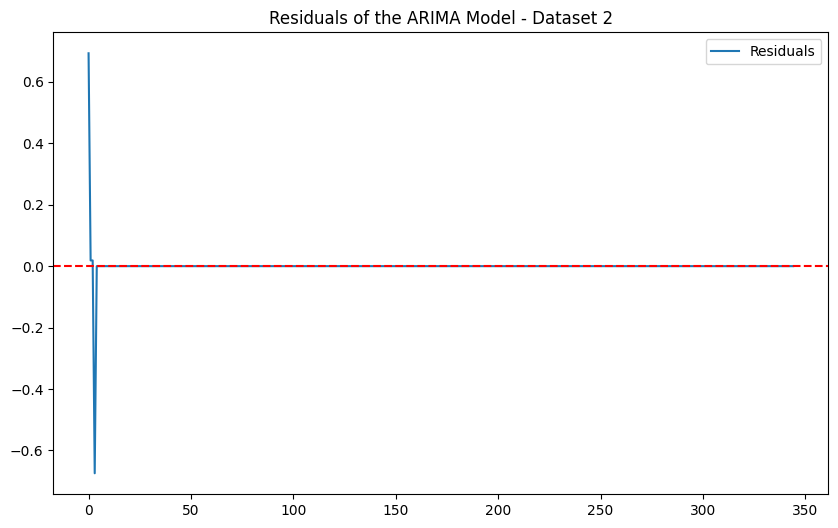

Dataset 3

Ljung-Box Test:
       lb_stat     lb_pvalue
10  255.577309  3.643766e-49

Recommended lb_pvalue is > 0.05

Jarque-Bera Test:
JB Test Stat: 2641660.559972813, p-value: 0.0

Recommended p-value is > 0.05

Durbin-Watson Test:
Durbin-Watson Stat: 1.1694019915506324

Recommended stat close to 2.0 but not greater than 2.0

RMSE:
Root Mean Squared Error: 0.012167026140466178


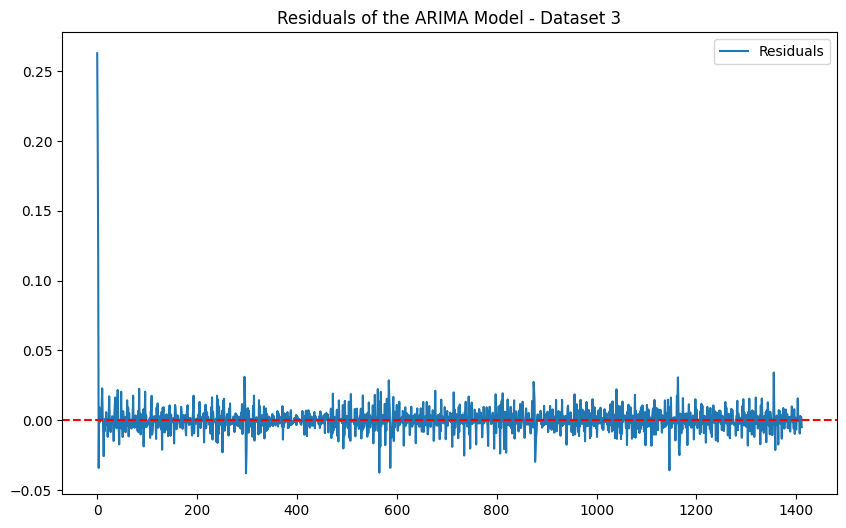

Dataset 4

Ljung-Box Test:
       lb_stat     lb_pvalue
10  212.483198  3.993291e-40

Recommended lb_pvalue is > 0.05

Jarque-Bera Test:
JB Test Stat: 2898537.0438523605, p-value: 0.0

Recommended p-value is > 0.05

Durbin-Watson Test:
Durbin-Watson Stat: 1.2040418203713334

Recommended stat close to 2.0 but not greater than 2.0

RMSE:
Root Mean Squared Error: 0.011998420807773053


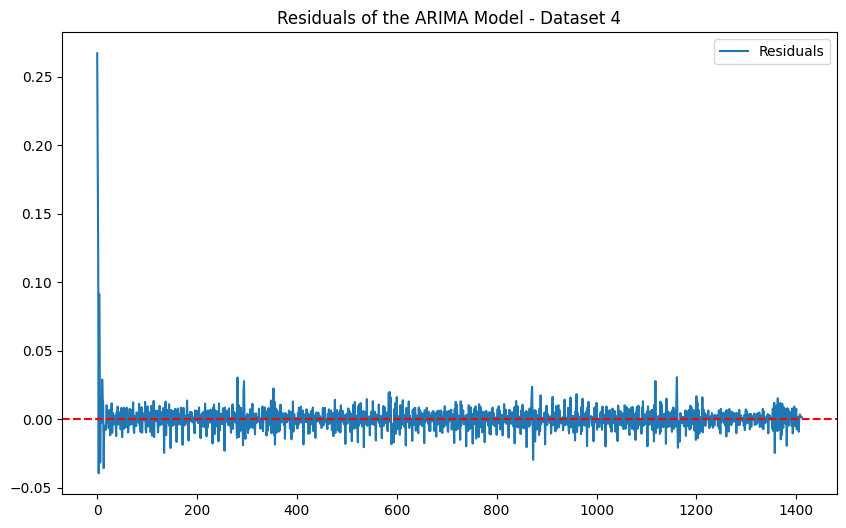

Dataset 5

Ljung-Box Test:
      lb_stat     lb_pvalue
10  74.903858  4.967258e-12

Recommended lb_pvalue is > 0.05

Jarque-Bera Test:
JB Test Stat: 1710172.922586373, p-value: 0.0

Recommended p-value is > 0.05

Durbin-Watson Test:
Durbin-Watson Stat: 1.990148111218093

Recommended stat close to 2.0 but not greater than 2.0

RMSE:
Root Mean Squared Error: 0.027689086248768948


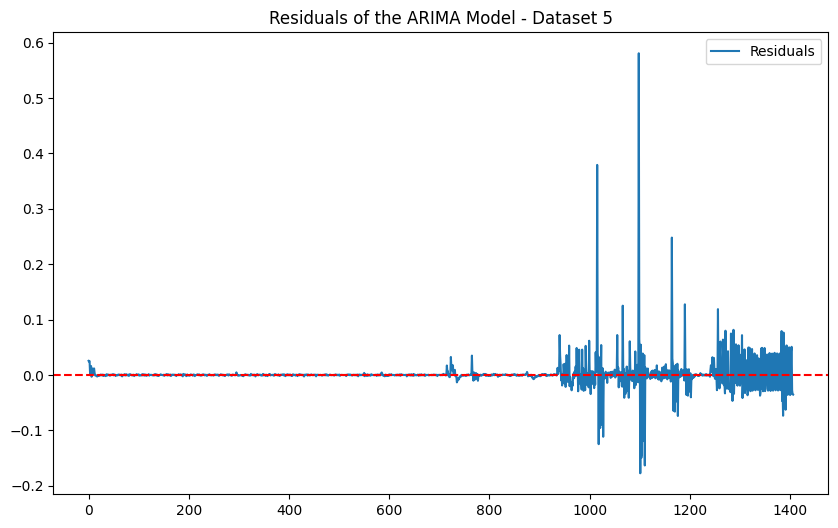

Dataset 6

Ljung-Box Test:
     lb_stat     lb_pvalue
10  88.34042  1.141912e-14

Recommended lb_pvalue is > 0.05

Jarque-Bera Test:
JB Test Stat: 2293578.8267521653, p-value: 0.0

Recommended p-value is > 0.05

Durbin-Watson Test:
Durbin-Watson Stat: 1.3615873693404594

Recommended stat close to 2.0 but not greater than 2.0

RMSE:
Root Mean Squared Error: 0.011020054791436808


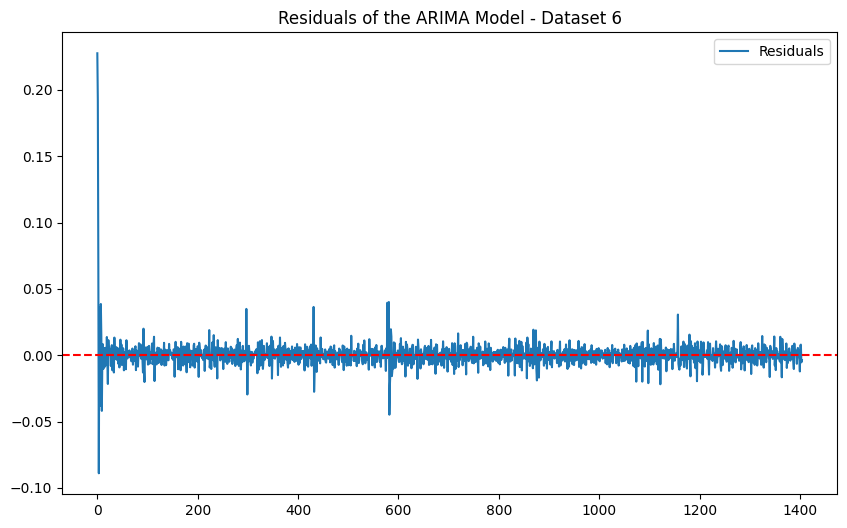

Dataset 7

Ljung-Box Test:
      lb_stat  lb_pvalue
10  45.190481   0.000002

Recommended lb_pvalue is > 0.05

Jarque-Bera Test:
JB Test Stat: 23813.039256761254, p-value: 0.0

Recommended p-value is > 0.05

Durbin-Watson Test:
Durbin-Watson Stat: 0.9392195888734121

Recommended stat close to 2.0 but not greater than 2.0

RMSE:
Root Mean Squared Error: 0.026185720296073342


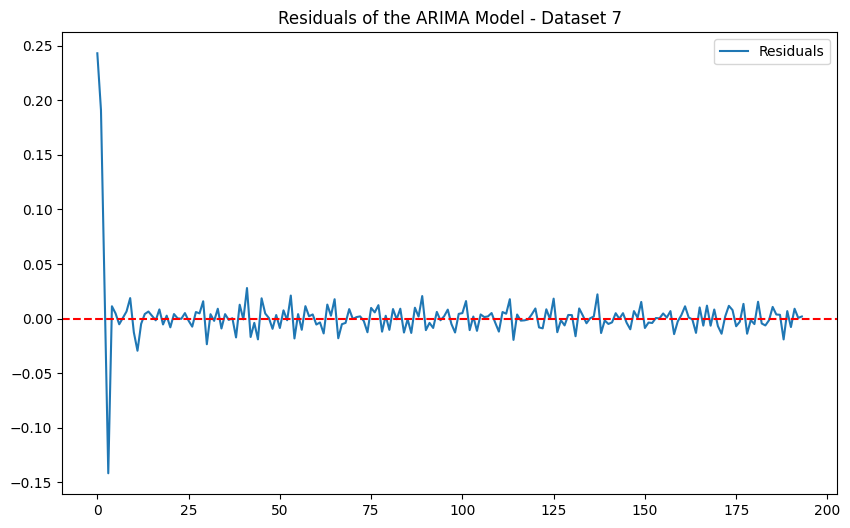

Dataset 8

Ljung-Box Test:
      lb_stat  lb_pvalue
10  10.253626   0.418531

Recommended lb_pvalue is > 0.05

Jarque-Bera Test:
JB Test Stat: 643.145452623058, p-value: 2.201605149285338e-140

Recommended p-value is > 0.05

Durbin-Watson Test:
Durbin-Watson Stat: 1.711978215433271

Recommended stat close to 2.0 but not greater than 2.0

RMSE:
Root Mean Squared Error: 0.12918086079112956


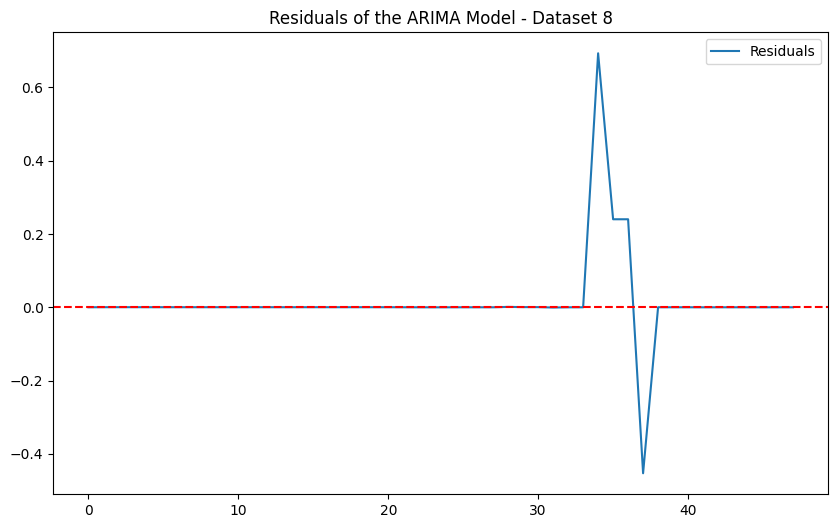

Dataset 9

Ljung-Box Test:
     lb_stat  lb_pvalue
10  9.766452   0.461217

Recommended lb_pvalue is > 0.05

Jarque-Bera Test:
JB Test Stat: 86.12402173794129, p-value: 1.987953858422983e-19

Recommended p-value is > 0.05

Durbin-Watson Test:
Durbin-Watson Stat: 1.7005061021658292

Recommended stat close to 2.0 but not greater than 2.0

RMSE:
Root Mean Squared Error: 0.17105970123964878


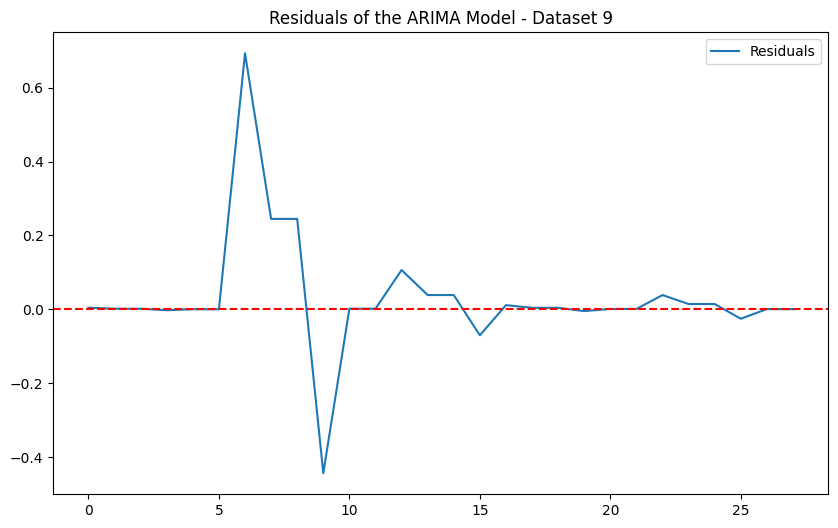


Summary of Test Results:

Results for Dataset 1:
Ljung-Box Test:       lb_stat  lb_pvalue
10  34.233398   0.000169
Jarque-Bera Test: {'JB Test Stat': 4.639661970621584, 'p-value': 0.09829019668760881}
Durbin-Watson Test: 2.0264527907277228
RMSE: 0.11774720370030548

Results for Dataset 2:
Ljung-Box Test:       lb_stat     lb_pvalue
10  87.279424  1.851543e-14
Jarque-Bera Test: {'JB Test Stat': 412386.9297002611, 'p-value': 0.0}
Durbin-Watson Test: 1.4852689872736085
RMSE: 0.05208331007579722

Results for Dataset 3:
Ljung-Box Test:        lb_stat     lb_pvalue
10  255.577309  3.643766e-49
Jarque-Bera Test: {'JB Test Stat': 2641660.559972813, 'p-value': 0.0}
Durbin-Watson Test: 1.1694019915506324
RMSE: 0.012167026140466178

Results for Dataset 4:
Ljung-Box Test:        lb_stat     lb_pvalue
10  212.483198  3.993291e-40
Jarque-Bera Test: {'JB Test Stat': 2898537.0438523605, 'p-value': 0.0}
Durbin-Watson Test: 1.2040418203713334
RMSE: 0.011998420807773053

Results for Dataset 5:
Ljung-Box

In [8]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
from statsmodels.stats.stattools import durbin_watson
import numpy as np
import matplotlib.pyplot as plt

# Store results for later printing
test_results = []

# Iterate through each fitted model
for i, model_fit in enumerate(fitted_models):
    # Extract residuals
    residuals = model_fit.resid
    result = {"Dataset": i+1}  # Store dataset number
   
    print(f"Dataset {i+1}")

    # 1. Ljung-Box test for autocorrelation in residuals (Begin with 10 Lags)
    ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    result["Ljung-Box Test"] = ljung_box_test
    print("\nLjung-Box Test:")
    print(ljung_box_test)
    print("\nRecommended lb_pvalue is > 0.05")
   
    # 2. Jarque-Bera test for normality of residuals
    jb_test_stat, jb_p_value = jarque_bera(residuals)
    result["Jarque-Bera Test"] = {"JB Test Stat": jb_test_stat, "p-value": jb_p_value}
    print("\nJarque-Bera Test:")
    print(f"JB Test Stat: {jb_test_stat}, p-value: {jb_p_value}")
    print("\nRecommended p-value is > 0.05")
   
    # 3. Durbin-Watson test for autocorrelation in residuals
    dw_stat = durbin_watson(residuals)
    result["Durbin-Watson Test"] = dw_stat
    print("\nDurbin-Watson Test:")
    print(f"Durbin-Watson Stat: {dw_stat}")
    print("\nRecommended stat close to 2.0 but not greater than 2.0")
   
    # 4. Residual Standard Error (RMSE) test for relative performance
    rmse = np.sqrt(np.mean(residuals**2))
    result["RMSE"] = rmse
    print("\nRMSE:")
    print(f"Root Mean Squared Error: {rmse}")
   
    # 5. Residual Plot (Optional for visual inspection)
    plt.figure(figsize=(10,6))
    plt.plot(residuals, label="Residuals")
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f"Residuals of the ARIMA Model - Dataset {i+1}")
    plt.legend()
    plt.show()

    # Append result for later summary
    test_results.append(result)

# Print the summary of all results after the loop
print("\nSummary of Test Results:")
for result in test_results:
    print(f"\nResults for Dataset {result['Dataset']}:")
    for test_name, test_result in result.items():
        if test_name != "Dataset":
            print(f"{test_name}: {test_result}")

Further Investigate Residuals

Outliers detected at the following indices:
6    0.693107
dtype: float64


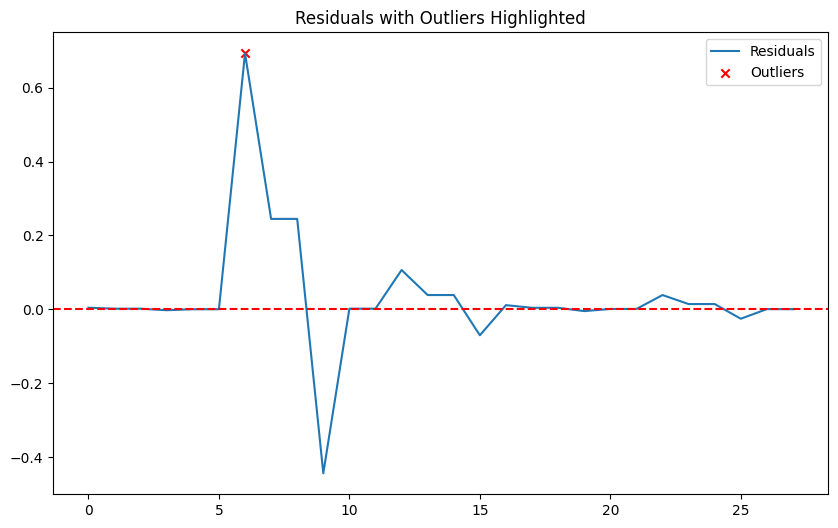

In [9]:
#Calculate the residuals from your fitted ARIMA model
residuals = model_fit.resid

#Calculate the mean and standard deviation of residuals
residual_mean = np.mean(residuals)
residual_std = np.std(residuals)

#Set a threshold for outliers (e.g., 3 standard deviations)
outlier_threshold = 3 * residual_std

#Identify the outliers
outliers = residuals[(residuals > residual_mean + outlier_threshold) | (residuals < residual_mean - outlier_threshold)]

#Print the identified outliers
print("Outliers detected at the following indices:")
print(outliers)

#Plot the residuals with outliers highlighted
plt.figure(figsize=(10, 6))
plt.plot(residuals, label="Residuals")
plt.scatter(outliers.index, outliers, color='red', label="Outliers", marker='x')
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals with Outliers Highlighted")
plt.legend()
plt.show()

Model Testing

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Initialize metrics storage
results = []

for i, (model_fit, df_test) in enumerate(zip(fitted_models, df_test_list)):
    print(f"Evaluating model for Dataset {i+1}...")
    try:
        # Get actual values
        y_true = df_test['sum_orig_bytes_log'].values

        # Predict using the fitted model
        forecast = model_fit.get_forecast(steps=len(y_true))
        y_pred = forecast.predicted_mean

        # Evaluate metrics
        residuals = y_true - y_pred
        threshold = 5.2  # Replace with your anomaly threshold if applicable
        anomalies_true = (np.abs(residuals) > threshold).astype(int)
        anomalies_pred = (np.abs(y_pred - y_true) > threshold).astype(int)

        # Compute metrics
        accuracy = accuracy_score(anomalies_true, anomalies_pred)
        precision = precision_score(anomalies_true, anomalies_pred, zero_division=0)
        recall = recall_score(anomalies_true, anomalies_pred, zero_division=0)
        f1 = f1_score(anomalies_true, anomalies_pred, zero_division=0)

        # AUC (requires binary classification)
        auc = roc_auc_score(anomalies_true, y_pred) if len(np.unique(anomalies_true)) > 1 else "N/A"

        # Store the results
        results.append({
            "Dataset": i + 1,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "AUC": auc
        })

        # Print the metrics for the dataset
        print(f"Results for Dataset {i+1}:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  AUC: {auc if auc == 'N/A' else round(auc, 4)}")

    except Exception as e:
        print(f"Error testing model for dataset {i+1}: {e}")
        results.append({
            "Dataset": i + 1,
            "Error": str(e)
        })

# Print summary of all results
print("\nSummary of Results:")
for result in results:
    if "Error" in result:
        print(f"Dataset {result['Dataset']}: Error - {result['Error']}")
    else:
        print(f"Dataset {result['Dataset']}: Accuracy={result['Accuracy']:.4f}, "
              f"Precision={result['Precision']:.4f}, Recall={result['Recall']:.4f}, "
              f"F1 Score={result['F1 Score']:.4f}, AUC={result['AUC'] if result['AUC'] == 'N/A' else round(result['AUC'], 4)}")

Evaluating model for Dataset 1...
Results for Dataset 1:
  Accuracy: 1.0000
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  AUC: N/A
Evaluating model for Dataset 2...
Results for Dataset 2:
  Accuracy: 1.0000
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  AUC: N/A
Evaluating model for Dataset 3...
Results for Dataset 3:
  Accuracy: 1.0000
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  AUC: N/A
Evaluating model for Dataset 4...
Results for Dataset 4:
  Accuracy: 1.0000
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  AUC: N/A
Evaluating model for Dataset 5...
Results for Dataset 5:
  Accuracy: 1.0000
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  AUC: N/A
Evaluating model for Dataset 6...
Results for Dataset 6:
  Accuracy: 1.0000
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  AUC: N/A
Evaluating model for Dataset 7...
Results for Dataset 7:
  Accuracy: 1.0000
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  AUC: N/A